In [184]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
%cd "C:\Users\Gamer\Desktop\CISC 451\CISC451\a2"

C:\Users\Gamer\Desktop\CISC 451\CISC451\a2


In [185]:
df = pd.read_csv("data/C2T1_Train.csv")
df2 = pd.read_csv("data/C2T1_Test.csv")

In [186]:
df.shape

(90766, 50)

In [187]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90766 entries, 0 to 90765
Data columns (total 50 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   encounter_id2             90766 non-null  int64 
 1   patient_nbr2              90766 non-null  int64 
 2   race                      90766 non-null  object
 3   gender                    90766 non-null  object
 4   age                       90766 non-null  object
 5   weight                    90766 non-null  object
 6   admission_type_id         90766 non-null  int64 
 7   discharge_disposition_id  90766 non-null  int64 
 8   admission_source_id       90766 non-null  int64 
 9   time_in_hospital          90766 non-null  int64 
 10  payer_code                90766 non-null  object
 11  medical_specialty         90766 non-null  object
 12  num_lab_procedures        90766 non-null  int64 
 13  num_procedures            90766 non-null  int64 
 14  num_medications       

In [188]:
df.head()

,encounter_id2,patient_nbr2,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,5283,48330653,Caucasian,Female,[80-90),?,2,1,4,13,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
1,8499,63555809,Caucasian,Female,[90-100),?,3,3,4,12,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2,9441,42519137,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
3,20997,89868902,AfricanAmerican,Female,[40-50),?,1,1,7,9,...,No,Steady,No,No,No,No,No,No,Yes,>30
4,28515,82637321,Caucasian,Male,[50-60),?,2,1,2,3,...,No,Steady,No,No,No,No,No,No,Yes,>30


In [189]:
df.groupby('readmitted').size()

readmitted
<30    10173
>30    31232
NO     49361
dtype: int64

# Modifying to Account for Multi-class Classification
Here we need to assign classes for all possible 'readmitted' values, so we assign classes 0, 1, and 2. The pre-processing logic done for the binary classifier remains the same for simplicity, with a few necessary modifications made in model selection to support multiple classes

In [190]:
# let's make the output variable binary so we can approach the first binary classification task
df['readmitted']=pd.Series([0 if x=='NO' else 1 if x=='>30' else 2 for x in df['readmitted']])


In [191]:
df = pd.concat([df,df2]) # bring in the test set so it can be pre-processed the same as the training set now that the target column has been made binary

In [192]:
df = df.replace('?',np.nan)

<AxesSubplot:xlabel='readmitted'>

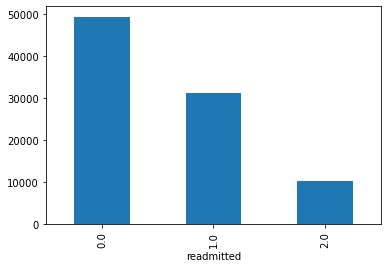

In [193]:
df.groupby('readmitted').size().plot(kind='bar')

Now we look at the unique values found in the different columns.


In [194]:
# for each column
for column in df.columns:
    # get a list of all unique values in the column
    unique = df[column].unique()
    # Print the column name and number on null values
    print(f"{column}:\n{df[column].isnull().sum()} Null values")
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(unique)<30:
        print(unique)
    else:
        print(f'{len(unique)} unique values')
    print('\n')

encounter_id2:
11000 Null values
90767 unique values


patient_nbr2:
11000 Null values
65766 unique values


race:
2273 Null values
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']


gender:
0 Null values
['Female' 'Male' 'Unknown/Invalid']


age:
0 Null values
['[80-90)' '[90-100)' '[40-50)' '[50-60)' '[60-70)' '[70-80)' '[20-30)'
 '[10-20)' '[30-40)' '[0-10)']


weight:
98569 Null values
[nan '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']


admission_type_id:
0 Null values
[2 3 1 6 4 5 8 7]


discharge_disposition_id:
0 Null values
[ 1  3  6  2  5 11  7 25 10  4 14 18  8 13 12 16 17 22 23  9 20 15 24 28
 19 27]


admission_source_id:
0 Null values
[ 4  7  2  1  5  6 20  3 17  8  9 14 10 11 22 25 13]


time_in_hospital:
0 Null values
[13 12  1  9  3  7 10  4  5  2  6 11  8 14]


payer_code:
40256 Null values
[nan 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']


medical_specialty:
49

Combine weight categories near the extremes to reduce the number of categories without losing too much information

Text(0, 0.5, 'Count')

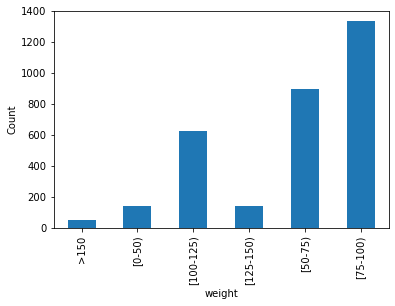

In [145]:
df['weight'] = pd.Series(['[0-50)' if val in ['[0-25)', '[25-50)'] else val 
                         for val in df['weight']], index=df.index)
df['weight'] = pd.Series(['>150' if val in ['[150-175)', '[175-200)', '>200'] else val 
                         for val in df['weight']], index=df.index)

df.groupby('weight').size().plot(kind='bar')
plt.ylabel('Count')

Do the same with the height

Text(0, 0.5, 'Count')

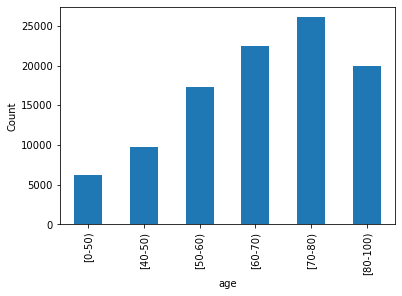

In [146]:
df['age'] = pd.Series(['[0-50)' if val in ['[0-10)', '[10-20)', '[20-30)', '[30-40)'] else val 
                         for val in df['age']], index=df.index)
df['age'] = pd.Series(['[80-100)' if val in ['[80-90)', '[90-100)'] else val 
                         for val in df['age']], index=df.index)

df.groupby('age').size().plot(kind='bar')
plt.ylabel('Count')

Now we split the discharge_disposition_id column into three distinct categories: "Home", "Death", and "Other"

Text(0, 0.5, 'Count')

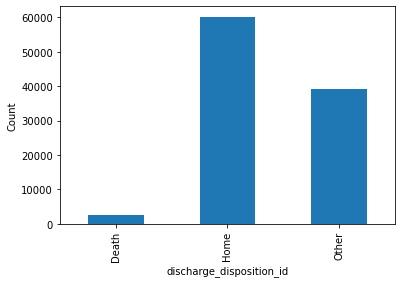

In [147]:
df['discharge_disposition_id'] = pd.Series(['Home' if val == 1 else 'Death' if val in [11,13,14,19,20,21] else 'Other' 
                                              for val in df['discharge_disposition_id']], index=df.index)
df.groupby('discharge_disposition_id').size().plot(kind='bar')
plt.ylabel('Count')

Combine id's corresponding to unknown values

Text(0, 0.5, 'Count')

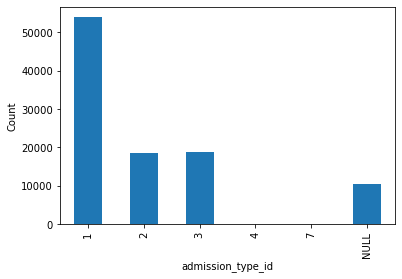

In [148]:
df['admission_type_id'] = pd.Series(['NULL' if val in [5, 6, 8] else val for val in df['admission_type_id']], index=df.index)
df.groupby('admission_type_id').size().plot(kind='bar')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

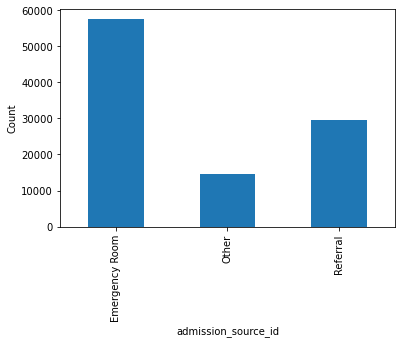

In [149]:
df['admission_source_id'] = pd.Series(['Referral' if val == 1 else 'Emergency Room' if val == 7 else 'Other' 
                                              for val in df['admission_source_id']], index=df.index)
df.groupby('admission_source_id').size().plot(kind='bar')
plt.ylabel('Count')

In [150]:
df.groupby('admission_source_id').size()

admission_source_id
Emergency Room    57494
Other             14707
Referral          29565
dtype: int64

In [151]:
categorical_columns = ['race', 'gender', 'weight',
       'max_glu_serum', 'A1Cresult', 'age', 'discharge_disposition_id', 
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'admission_type_id','examide','citoglipton',
       'glyburide-metformin', 'glipizide-metformin', 'admission_source_id',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'medical_specialty']
df[categorical_columns].isnull().sum()

race                         2273
gender                          0
weight                      98569
max_glu_serum                   0
A1Cresult                       0
age                             0
discharge_disposition_id        0
metformin                       0
repaglinide                     0
nateglinide                     0
chlorpropamide                  0
glimepiride                     0
acetohexamide                   0
glipizide                       0
glyburide                       0
tolbutamide                     0
pioglitazone                    0
rosiglitazone                   0
acarbose                        0
miglitol                        0
troglitazone                    0
tolazamide                      0
insulin                         0
admission_type_id               0
examide                         0
citoglipton                     0
glyburide-metformin             0
glipizide-metformin             0
admission_source_id             0
glimepiride-pi

Fill all missing categorical data with "UNK" category

In [152]:
df['race'] = df['race'].fillna('UNK')
df['weight'] = df['weight'].fillna('UNK')
df['payer_code'] = df['payer_code'].fillna('UNK')
df['medical_specialty'] = df['medical_specialty'].fillna('UNK')

Investigate contents of medical_specialty column

In [153]:
df.groupby('medical_specialty').size().sort_values(ascending = False)

medical_specialty
UNK                                 49949
InternalMedicine                    14635
Emergency/Trauma                     7565
Family/GeneralPractice               7440
Cardiology                           5352
                                    ...  
Psychiatry-Addictive                    1
Dermatology                             1
Speech                                  1
SportsMedicine                          1
Surgery-PlasticwithinHeadandNeck        1
Length: 73, dtype: int64

Keep all categories with more than 500 occurances

In [154]:
cats_to_keep = [
    'UNK','InternalMedicine','Emergency/Trauma',
    'Family/GeneralPractice', 'Cardiology','Surgery-General',
    'Nephrology','Orthopedics', 'Orthopedics-Reconstructive',
    'Radiologist0', 'Pulmonology', 'Psychiatry', 'Urology',
    'Surgery-Cardiovascular/Thoracic', 'ObstetricsandGynecology']
# replace all specialties not in top 10 with 'Other' category
df.loc[~df.medical_specialty.isin(cats_to_keep),'medical_specialty'] = 'Other'
df.groupby('medical_specialty').size()

medical_specialty
Cardiology                          5352
Emergency/Trauma                    7565
Family/GeneralPractice              7440
InternalMedicine                   14635
Nephrology                          1613
ObstetricsandGynecology              671
Orthopedics                         1400
Orthopedics-Reconstructive          1233
Other                               5747
Psychiatry                           854
Pulmonology                          871
Surgery-Cardiovascular/Thoracic      652
Surgery-General                     3099
UNK                                49949
Urology                              685
dtype: int64

Prepare admission_type_id for one-hot encoding by convertring numerical data into strings

In [155]:
df['admission_type_id'] = df['admission_type_id'].astype('str')

Use get_dummies with drop_first to one-hot encode the categorical features while leaving one category out

In [156]:
categorical_df = pd.get_dummies(df[categorical_columns],drop_first = True)
categorical_df.head()

,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_UNK,gender_Male,gender_Unknown/Invalid,weight_UNK,weight_[0-50),weight_[100-125),...,medical_specialty_ObstetricsandGynecology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Pulmonology,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-General,medical_specialty_UNK,medical_specialty_Urology
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [157]:
one_hot_columns = list(categorical_df.columns)
df = pd.concat([df,categorical_df], axis = 1)

In [158]:
df.head()

,encounter_id2,patient_nbr2,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,medical_specialty_ObstetricsandGynecology,medical_specialty_Orthopedics,medical_specialty_Orthopedics-Reconstructive,medical_specialty_Other,medical_specialty_Psychiatry,medical_specialty_Pulmonology,medical_specialty_Surgery-Cardiovascular/Thoracic,medical_specialty_Surgery-General,medical_specialty_UNK,medical_specialty_Urology
0,5283.0,48330653.0,Caucasian,Female,[80-100),UNK,2,Home,Other,13,...,0,0,0,0,0,0,0,0,1,0
1,8499.0,63555809.0,Caucasian,Female,[80-100),UNK,3,Other,Other,12,...,0,0,0,0,0,0,0,0,0,0
2,9441.0,42519137.0,Caucasian,Male,[40-50),UNK,1,Home,Emergency Room,1,...,0,0,0,0,0,0,0,0,1,0
3,20997.0,89868902.0,AfricanAmerican,Female,[40-50),UNK,1,Home,Emergency Room,9,...,0,0,0,0,0,0,0,0,1,0
4,28515.0,82637321.0,Caucasian,Male,[50-60),UNK,2,Home,Other,3,...,0,0,0,0,0,0,0,0,1,0


In [159]:
numerical_columns = ['time_in_hospital','num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient','number_diagnoses']
df[numerical_columns].isnull().sum()

time_in_hospital      0
num_lab_procedures    0
num_procedures        0
num_medications       0
number_outpatient     0
number_emergency      0
number_inpatient      0
number_diagnoses      0
dtype: int64

## Diagnosis

Many unique values... 

### Primary Diagnosis
We seperate into ones that relate to diabetes (code starts with "250") and ones that don't.

### Secondary/Tertiary
Drop them

In [160]:
df['diag_1'] = pd.Series([1 if val.startswith('250') else 0 for val in df['diag_1'].astype('str')], index=df.index)

In [161]:
features = numerical_columns + one_hot_columns + ["diag_1"]
# features = [f for f in features if not f startswith('weight')]

In [162]:
df[features].shape

(101766, 106)

In [163]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import resample
from make_confusion_matrix import make_confusion_matrix
from plot_roc_curve import plot_roc_curve
from validate_model_multiclass import validate_model

Resample the data (using downsampling) so that we have an equal number of each outcome.

In [164]:
# Separate minority class from the other two
df_majority0 = df[df.readmitted==0]
df_majority1 = df[df.readmitted==1]
df_minority = df[df.readmitted==2]
num_samples = df_minority.shape[0]
num_samples

10173

In [165]:
# Downsample majority classes
df_majority0_downsampled = resample(
                            df_majority0,
                            replace=False,
                            n_samples=num_samples,
                            random_state=123)
df_majority1_downsampled = resample(
                            df_majority1,
                            replace=False,
                            n_samples=num_samples,
                            random_state=123)
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority0_downsampled, df_majority1_downsampled, df_minority])
 
# Display new class counts
df_downsampled.readmitted.value_counts()

2.0    10173
1.0    10173
0.0    10173
Name: readmitted, dtype: int64

In [166]:
x = df_downsampled[features]
y = df_downsampled['readmitted']
# X_train, X_test, y_train, y_test = train_test_split(
#      x, y, test_size=0.4, random_state=0)


In [167]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
categories = ["Not Readmitted", "Readmitted"]

In [168]:
knnc = KNeighborsClassifier()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

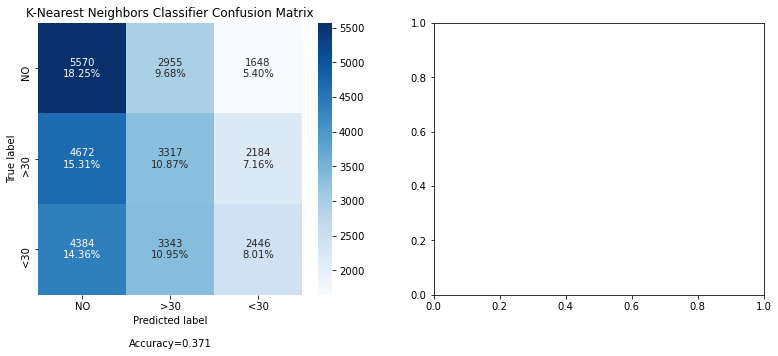

<Figure size 432x288 with 0 Axes>

In [183]:
validate_model(knnc, x, y, 'K-Nearest Neighbors Classifier', group_names=group_names, categories=['NO','>30','<30'])

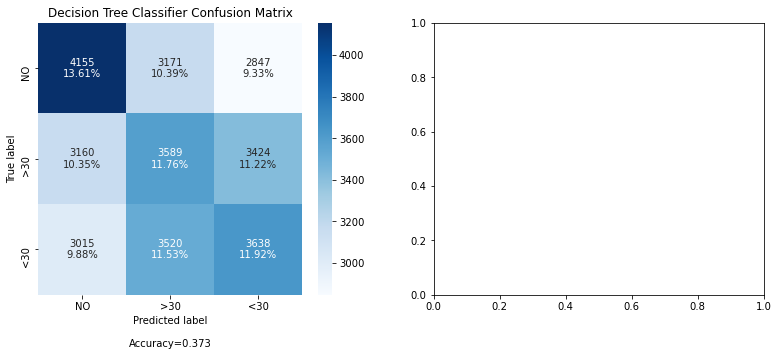

<Figure size 432x288 with 0 Axes>

In [133]:
validate_model(dtc, x, y, 'Decision Tree Classifier', group_names=group_names, categories=['NO','>30','<30'])

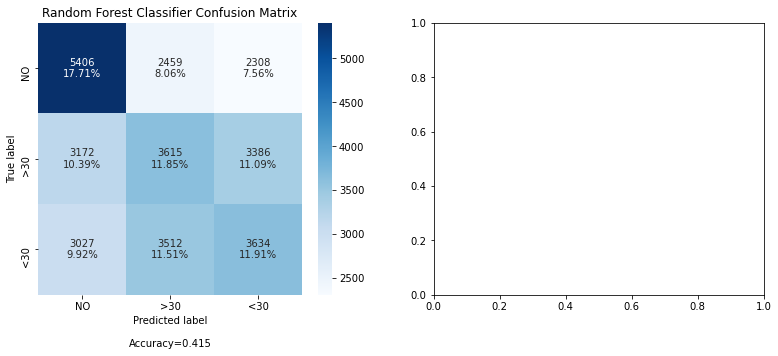

<Figure size 432x288 with 0 Axes>

In [182]:
validate_model(rfc, x, y, 'Random Forest Classifier', group_names=group_names, categories=['NO','>30','<30'])

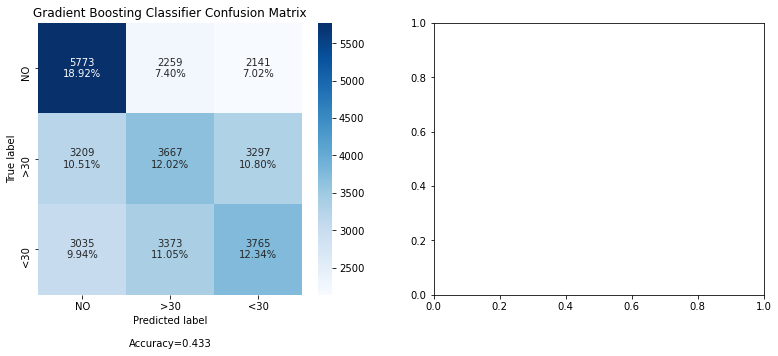

<Figure size 432x288 with 0 Axes>

In [181]:
validate_model(gbc, x, y, 'Gradient Boosting Classifier', group_names=group_names, categories=['NO','>30','<30'])

In [170]:
from sklearn.model_selection import GridSearchCV

In [180]:
selected_model = gbc = GradientBoostingClassifier(min_samples_split=500, min_samples_leaf=50, max_depth=8, max_features='sqrt', subsample=0.8, random_state=10)

n_trees_search = GridSearchCV(estimator=selected_model, param_grid={'n_estimators':range(20,101,10)}, scoring='f1_weighted', n_jobs=4, cv=5)
n_trees_search.fit(x, y)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 101, 10)},
             scoring='f1_micro')

In [95]:
n_trees = n_trees_search.best_params_['n_estimators']
n_trees_search.cv_results_, n_trees_search.best_params_, n_trees_search.best_score_


({'mean_fit_time': array([ 3.19477458,  4.71533542,  6.21106863,  7.50762687,  8.82436037,
         10.54349689, 11.61264606, 12.26752148, 12.88076744]),
  'std_fit_time': array([0.08974386, 0.17138179, 0.18645895, 0.08975973, 0.09418862,
         0.16651181, 0.45994772, 0.20376967, 1.19672493]),
  'mean_score_time': array([0.07550621, 0.09236956, 0.10756512, 0.11324716, 0.12407045,
         0.14686432, 0.14435301, 0.15894814, 0.14795103]),
  'std_score_time': array([0.00579032, 0.00897659, 0.00483968, 0.00622455, 0.00483853,
         0.01365701, 0.00621307, 0.00509734, 0.0246741 ]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80, 90, 100],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_e

In [96]:
refined_gbc = GradientBoostingClassifier(min_samples_leaf=50, n_estimators=n_trees, max_features='sqrt', subsample=0.8, random_state=10)
depth_split_grid = {'max_depth': range(5,16,2), 'min_samples_split': range(200,1601,200)}
depth_split_test = GridSearchCV(estimator=refined_gbc , param_grid=depth_split_grid, scoring='f1_weighted' ,n_jobs=-1, cv=5)
depth_split_test.fit(x, y)
depth = depth_split_test.best_params_['max_depth']
split = depth_split_test.best_params_['min_samples_split']
depth_split_test.cv_results_, depth_split_test.best_params_, depth_split_test.best_score_


({'mean_fit_time': array([ 8.27608275,  8.4390276 ,  8.42882991,  8.07914395,  8.35885401,
          8.05875216,  8.02996154,  8.2270968 , 11.38106046, 11.36506476,
         11.28649158, 10.98039074, 10.73787165, 10.80344858, 10.64230304,
         10.65469856, 14.52122841, 14.42266092, 14.10616622, 13.62172399,
         13.30062819, 13.02891941, 13.07690158, 12.96853795, 17.38968587,
         16.82027411, 16.4695889 , 15.7336307 , 15.48351192, 15.5242991 ,
         14.8695138 , 15.31776628, 19.81388836, 19.28526211, 18.44293942,
         17.82674236, 16.99341674, 17.44806561, 16.98102031, 16.11610446,
         21.96298242, 21.53872299, 20.93052278, 19.89106407, 19.47339754,
         19.06833405, 19.87026987, 19.81068945]),
  'std_fit_time': array([0.20884278, 0.51161723, 0.39293239, 0.35966716, 0.41008822,
         0.21277332, 0.25759439, 0.2087414 , 0.3360193 , 0.57333829,
         0.35386208, 0.27709128, 0.3042099 , 0.28033427, 0.37729023,
         0.486201  , 0.57458376, 0.40408207,

In [97]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, max_features='sqrt', subsample=0.8, random_state=10)
leaf_grid = {'min_samples_leaf':range(30,91,10)}
leaf_test = GridSearchCV(estimator=refined_gbc, param_grid=leaf_grid, scoring='f1_weighted',n_jobs=-1,cv=5)
leaf_test.fit(x, y)
leaf = leaf_test.best_params_['min_samples_leaf']
leaf_test.cv_results_, leaf_test.best_params_, leaf_test.best_score_


({'mean_fit_time': array([12.0802628 , 12.12247658, 12.38133326, 12.55832443, 12.55944624,
         12.18338714,  9.2065114 ]),
  'std_fit_time': array([0.55313578, 0.53381627, 0.57702575, 0.3738851 , 0.48786875,
         0.55330325, 2.40348018]),
  'mean_score_time': array([0.19800963, 0.19500923, 0.1768086 , 0.17500601, 0.1859726 ,
         0.1652071 , 0.12756529]),
  'std_score_time': array([0.03924353, 0.03324194, 0.01178025, 0.00668123, 0.0136312 ,
         0.0159276 , 0.0269389 ]),
  'param_min_samples_leaf': masked_array(data=[30, 40, 50, 60, 70, 80, 90],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'min_samples_leaf': 30},
   {'min_samples_leaf': 40},
   {'min_samples_leaf': 50},
   {'min_samples_leaf': 60},
   {'min_samples_leaf': 70},
   {'min_samples_leaf': 80},
   {'min_samples_leaf': 90}],
  'split0_test_score': array([0.50838231, 0.50906728, 0.51186353, 0.50965514, 0.50911764,
  

In [98]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, subsample=0.8, random_state=10)
features_grid = {'max_features':range(5,30,2)}
features_test = GridSearchCV(estimator=refined_gbc, param_grid=features_grid, scoring='f1_weighted', n_jobs=-1, cv=5)
features_test.fit(x, y)
features = features_test.best_params_['max_features']
features_test.cv_results_, features_test.best_params_, features_test.best_score_


({'mean_fit_time': array([ 8.47750487, 10.69986706, 12.08703499, 14.16799779, 14.76859789,
         16.78457246, 17.46973691, 18.71836228, 20.64878526, 23.05916195,
         22.61699729, 24.86683278, 21.67970777]),
  'std_fit_time': array([0.41872598, 0.66103016, 1.16960896, 1.05590357, 0.85735388,
         1.05682566, 0.77426436, 0.91134169, 0.70937955, 0.92365942,
         0.691874  , 0.61750054, 3.68058949]),
  'mean_score_time': array([0.19337721, 0.22850189, 0.19659338, 0.18061562, 0.18268681,
         0.17419038, 0.19077954, 0.18676801, 0.18421202, 0.17816706,
         0.18399405, 0.17612982, 0.11740623]),
  'std_score_time': array([0.00928745, 0.03940039, 0.04050381, 0.0149656 , 0.02042936,
         0.0152823 , 0.02774079, 0.01250049, 0.0179667 , 0.01870882,
         0.0243794 , 0.01652133, 0.02155533]),
  'param_max_features': masked_array(data=[5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29],
               mask=[False, False, False, False, False, False, False, False,
       

In [99]:
refined_gbc = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, random_state=10)
subsample_grid = {'subsample':[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]}
subsample_test = GridSearchCV(estimator=refined_gbc, param_grid=subsample_grid, scoring='f1_weighted', n_jobs=-1, cv=5)
subsample_test.fit(x, y)
subsample = subsample_test.best_params_['subsample']
subsample_test.cv_results_, subsample_test.best_params_, subsample_test.best_score_


({'mean_fit_time': array([16.79455204, 18.56275892, 19.8498064 , 20.85121517, 22.98572998,
         23.45158534, 23.95407696, 25.86923747, 20.40535245]),
  'std_fit_time': array([0.56182075, 0.4571473 , 0.66493497, 0.75264873, 1.0428047 ,
         0.5341341 , 0.66838126, 0.67044284, 2.02053831]),
  'mean_score_time': array([0.18299479, 0.18037601, 0.19300585, 0.17839918, 0.19015689,
         0.1736155 , 0.18236618, 0.17657151, 0.10827656]),
  'std_score_time': array([0.01068714, 0.01235837, 0.00681826, 0.02477613, 0.02339016,
         0.01329997, 0.02093344, 0.02112341, 0.01992002]),
  'param_subsample': masked_array(data=[0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.5},
   {'subsample': 0.55},
   {'subsample': 0.6},
   {'subsample': 0.65},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'sub

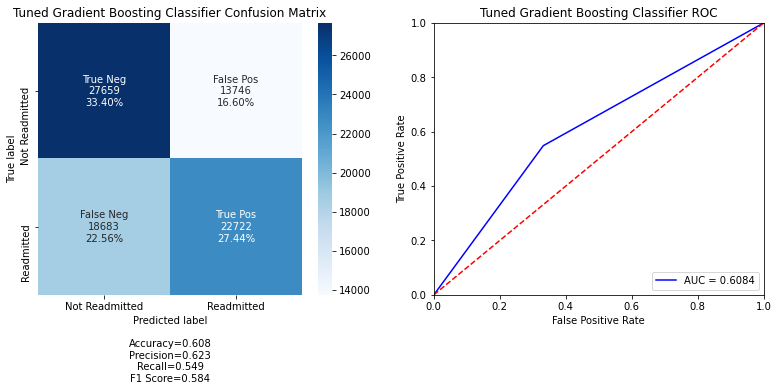

<Figure size 432x288 with 0 Axes>

In [100]:
tuned_model = GradientBoostingClassifier(n_estimators=n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, subsample=subsample, random_state=10)
validate_model(tuned_model, x, y, 'Tuned Gradient Boosting Classifier', group_names=group_names, categories=['NO','>30','<30'])

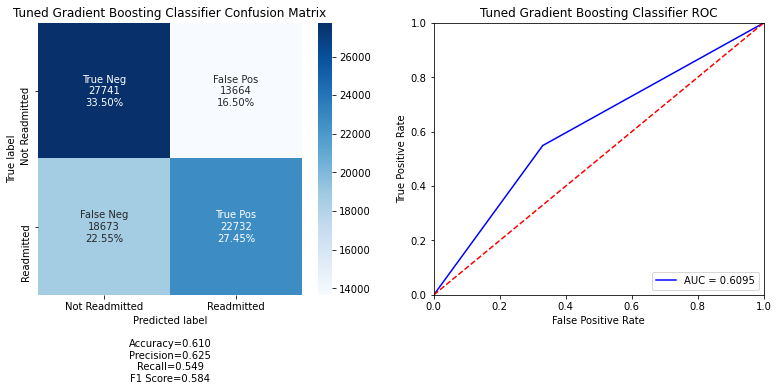

<Figure size 432x288 with 0 Axes>

In [101]:
better_tuned_model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=2*n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, subsample=subsample, random_state=10)
validate_model(better_tuned_model, x, y, 'Tuned Gradient Boosting Classifier', group_names=group_names, categories=['NO','>30','<30'])

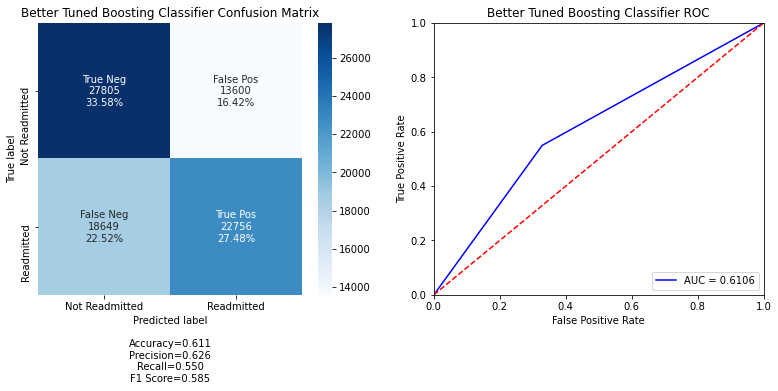

<Figure size 432x288 with 0 Axes>

In [102]:
expensive_tuned_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=10*n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, subsample=subsample, random_state=10)
validate_model(expensive_tuned_model, x, y, 'Better Tuned Boosting Classifier', group_names=group_names, categories=['NO','>30','<30'])

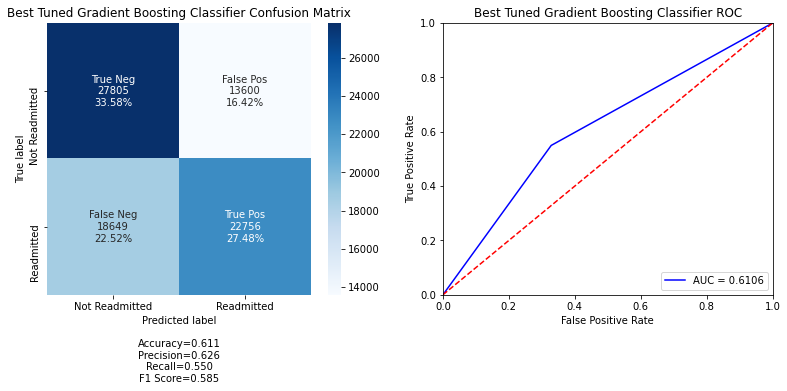

<Figure size 432x288 with 0 Axes>

In [103]:
crazy_tuned_model = GradientBoostingClassifier(learning_rate=0.005, n_estimators=25*n_trees, min_samples_split=split, max_depth=depth, min_samples_leaf=leaf, max_features=features, subsample=subsample, random_state=10)
validate_model(expensive_tuned_model, x, y, 'Best Tuned Gradient Boosting Classifier', group_names=group_names, categories=['NO','>30','<30'])

In [104]:
depth_split_test.best_params_, features_test.best_params_, leaf_test.best_params_, n_trees_search.best_params_, subsample_test.best_params_


({'max_depth': 7, 'min_samples_split': 1400},
 {'max_features': 27},
 {'min_samples_leaf': 50},
 {'n_estimators': 60},
 {'subsample': 0.6})

# Testing
Assessing the accuracy of our best model on the training data

In [121]:
x_test = df.loc[df['readmitted'].isnull()]
cols = numerical_columns + one_hot_columns + ["diag_1"]
x_test = x_test[cols]

In [123]:
crazy_tuned_model.fit(x,y)

GradientBoostingClassifier(learning_rate=0.005, max_depth=7, max_features=27,
                           min_samples_leaf=50, min_samples_split=1400,
                           n_estimators=1500, random_state=10, subsample=0.6)

In [128]:
predictions = crazy_tuned_model.predict(x_test)

In [129]:
tested = pd.read_csv("data/C2T1_Test.csv")


In [130]:
tested['readmitted'] = predictions

In [136]:
tested['readmitted'] = ['No' if x == 0.0 else 'Yes' for x in tested['readmitted']]
tested['readmitted']= ['NO' if x==0 else '>30' if x==1 else '<30' for x in tested['readmitted']])


In [137]:
tested = tested[['encounter_id','patient_nbr','readmitted']]
tested.to_csv('C2T1_Test_Labeled_30days.csv',index=False)

## Provided data

In [174]:
training_data = df.head(90766)

In [178]:
training_preds = crazy_tuned_model.predict(training_data[cols])

In [179]:
training_data['readmitted_pred'] = training_preds

In [197]:
correct_predictions = pd.crosstab(training_data.readmitted,training_data.readmitted_pred)

Above, the correct predictions are in the top-left and bottom-right, their sum divided by the number of training samples gives us our accuracy

In [202]:
(correct_predictions[0][0]+correct_predictions[1][1])/len(training_data)

0.6526452636449772